In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC
import time
import pandas as pd
import os

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'

# 一、设置可以调整的参数

In [20]:
nonroad = 50
road = 50
choice = np.array([0,1])
dimension = choice.size
pic_index = 1
pic_name = r'data\picData\%d.png'%pic_index


## 1、读取图像

In [21]:
RGB = cv2.imread(pic_name)
img = RGB.copy()
# 获取图片维度大小
m = RGB.shape[0]
n = RGB.shape[1]


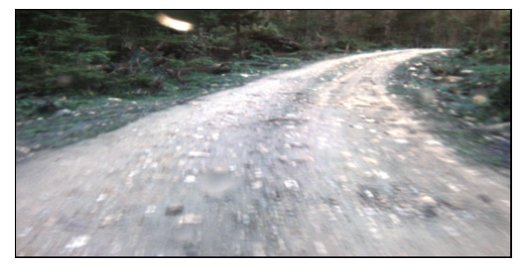

In [22]:
cv2.namedWindow("image")
cv2.imshow("image", img)

plt.xticks([])  #去掉横坐标值
plt.yticks([])  #去掉纵坐标值
plt.imshow(img)
plt.show()

# 调试模块

In [23]:
df = pd.read_excel(r'data\testData\2022_10_11_17_13_30__50 points.xls', header = 0)
trnx = df.iloc[:,choice].values
trny = df.iloc[:,-1:].values

# 二、结果显示

In [24]:
def plot_result(pic, model):
    reslm = np.zeros(pic.shape)
    # 获取图片维度大小
    m = RGB.shape[0]
    n = RGB.shape[1]
    for i in range(m):
        for j in range(n):
            testx = pic[i,j,choice].astype(np.double)
            testx = testx.reshape((1,dimension))
            preY = model.predict(testx)
            if preY > 0:
                reslm[i,j,:] = np.array([1.,1.,1.])
            else:
                reslm[i,j,:] = np.array([0,0,0])
    
    plt.xticks([])  #去掉横坐标值
    plt.yticks([])  #去掉纵坐标值
    plt.title('Sklearn:%s'%model.name, fontsize=16)
    plt.imshow(reslm)
    plt.show()
    

In [25]:
def plot_predictions(clf, x, y):
    x_min = np.min(x, 0)
    x_max = np.max(x, 0)
    
    flatten = lambda m: np.array(m).reshape(-1,)
    x0s = np.linspace(x_min[0], x_max[0], 100)
    x1s = np.linspace(x_min[1], x_max[1], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.xlabel("$x'_0$", fontsize=15)
    plt.ylabel("$x'_1$  ", fontsize=15, rotation=0)
    plt.title('Sklearn:%s'%clf.name, fontsize=16)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    plt.scatter(flatten(x[:, 0]), flatten(x[:, 1]),
                c=flatten(y),alpha=0.8, cmap=plt.cm.brg)
    plt.show()

# 二、库函数分类器

## 1.线性分类器 

C:\Users\JL\AppData\Local\conda\conda\envs\python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JL\AppData\Local\conda\conda\envs\python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


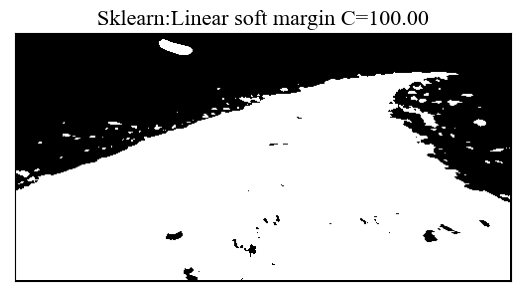

In [26]:
C = 100
svm_clf = Pipeline([("scaler", StandardScaler()),
                    ("linear_svc", LinearSVC(C=C, loss="hinge", random_state=42))])

svm_clf.fit(trnx, trny)
svm_clf.name = 'Linear soft margin C=%.2f'%(C)

plot_result(RGB, svm_clf)

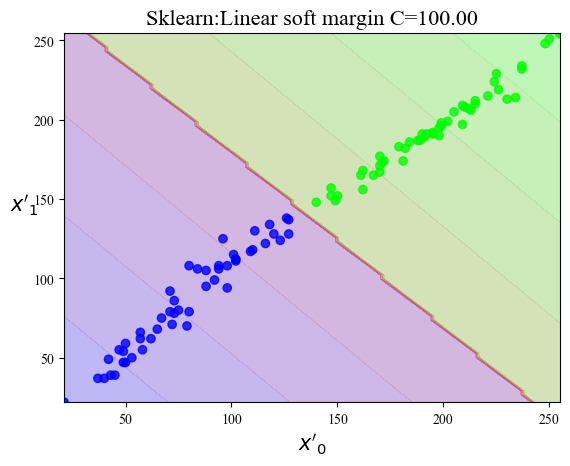

In [27]:
plot_predictions(svm_clf, trnx, trny)

## 2.非线性分类器 

C:\Users\JL\AppData\Local\conda\conda\envs\python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JL\AppData\Local\conda\conda\envs\python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


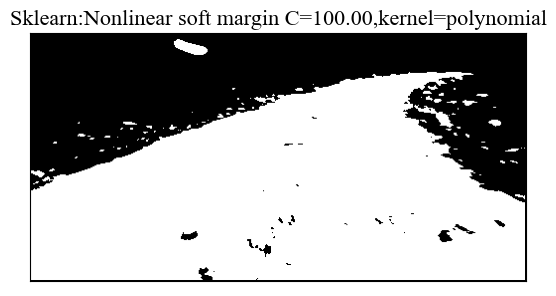

In [28]:
degree = 3
C = 100

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree = degree)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C = C, loss = "hinge"))
])

polynomial_svm_clf.fit(trnx, trny)
polynomial_svm_clf.name = 'Nonlinear soft margin C=%.2f,kernel=%s'%(C, "polynomial")

plot_result(RGB, polynomial_svm_clf)

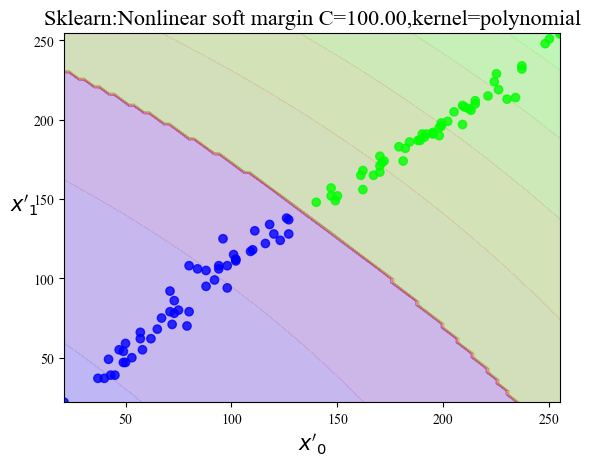

In [29]:
plot_predictions(polynomial_svm_clf, trnx, trny)

## 3.高斯RBF内核 

C:\Users\JL\AppData\Local\conda\conda\envs\python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


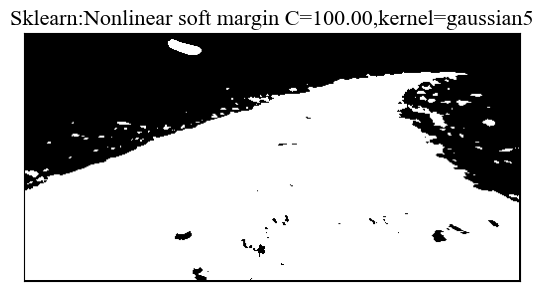

In [30]:
# 超参数，增加gamma的值会使钟形曲线变得更窄，因此每个实例的影响范围随之变小
# 决策边界变得不规则，围绕单个实例绕弯
# 减小gamma值使得钟形曲线变得更宽，每个实例的影响范围增大
# 决策边界变得平坦
# γ是一个正则化的超参数：模型过拟合，就降低它的值；欠拟合，就提升它的值
gamma_ = 5
C_ = 100

rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=gamma_, C = C_))
])

rbf_kernel_svm_clf.fit(trnx, trny)
rbf_kernel_svm_clf.name = 'Nonlinear soft margin C=%.2f,kernel=%s'%(C, "gaussian%d"%gamma_)

plot_result(RGB, rbf_kernel_svm_clf)

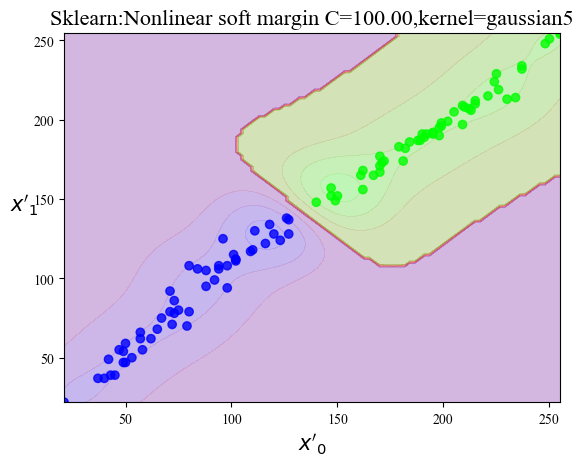

In [31]:
plot_predictions(rbf_kernel_svm_clf, trnx, trny)

## 4.多项式内核 

C:\Users\JL\AppData\Local\conda\conda\envs\python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


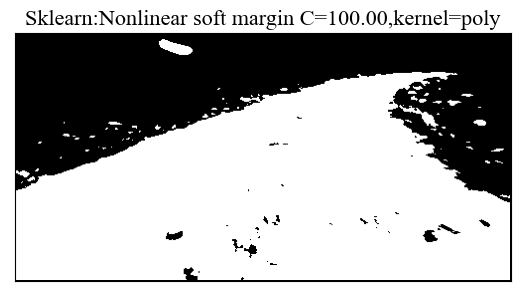

In [32]:
# 超参数，设置模型的阶数
degree_ = 3
# 超参数，控制模型受高阶多项式还是低阶多项式的影响程度
coef0_ = 1
# 权衡因子
C_ = 5

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=degree_, coef0=coef0_, C = C_))
])

poly_kernel_svm_clf.fit(trnx, trny)
poly_kernel_svm_clf.name = 'Nonlinear soft margin C=%.2f,kernel=%s'%(C, "poly")

plot_result(RGB, poly_kernel_svm_clf)

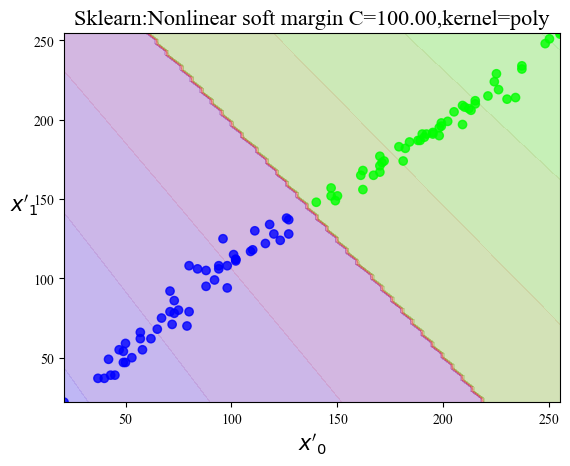

In [33]:
plot_predictions(poly_kernel_svm_clf, trnx, trny)